# LIME

In [1]:
%matplotlib inline
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import label2rgb

# MNISTデータセットの場合
## データセットの読み込み

In [2]:
train_data = torchvision.datasets.MNIST(
    root = "../data",
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
test_data = torchvision.datasets.MNIST(
    root = "../data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

## データセットの表示

Text(0.5, 1.0, 'Digit : 3')

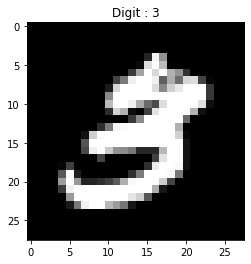

In [3]:
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)
# 辞書型変数にまとめると学習・検証の実施時に扱いやすくなる
dataloaders_dict = {"train" : train_dataloader, "test" : test_dataloader}
# イテレータに変換
batch_iterator = iter(dataloaders_dict["train"])
# 要素を取り出す
imgs, labels = next(batch_iterator)
fig, ax1 = plt.subplots(1, 1)
ax1.imshow(imgs[0].squeeze().numpy(), cmap = "gray")
ax1.set_title(f"Digit : {labels[0]}")

## 学習済みモデルの読み込み

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.loss_train_log = []
        self.loss_test_log = []
        self.acc_train_log = []
        self.acc_test_log = []
        
        # 1つの入力画像チャンネル、4 x 4の正方形畳み込み、32つの出力チャンネル
        self.Conv1 = nn.Conv2d( 1, 32, kernel_size = (4, 4), stride = (2, 2), padding = 1)
        # 32つの入力画像チャンネル、4 x 4の正方形畳み込み、64つの出力チャンネル
        self.Conv2 = nn.Conv2d(32, 64, kernel_size = (4, 4), stride = (2, 2), padding = 1)
        self.linear1 = nn.Linear(64 * 3 * 3, 128)
        self.linear2 = nn.Linear(128, 10)
        
        # 誤差関数の設定
        self.loss = nn.CrossEntropyLoss() 
        # 最適化手法の設定
        self.optimizer = optim.SGD(self.parameters(), lr = 1e-2)
        
    def forward(self, x):
        x = self.Conv1(x) # Size : 1 x 28 x 28 -> 32 x 14 x 14
        x = torch.relu(x)
        x = self.Conv2(x) # Size : 32 x 14 x 14 -> 64 x 7 x 7
        x = torch.relu(x)
        x = F.max_pool2d(x, 2) # 指定サイズの範囲内で最大の値を抽出する(Size : 64 x 7 x 7 -> 64 x 3 x 3)
        x = x.view(-1, 64 * 3 * 3) # ベクトルに変換
        x = self.linear1(x)
        x = torch.relu(x)
        return self.linear2(x)

# 学習済みモデルの読み込み
model = torch.load("../model/cnn_mnist.pth")

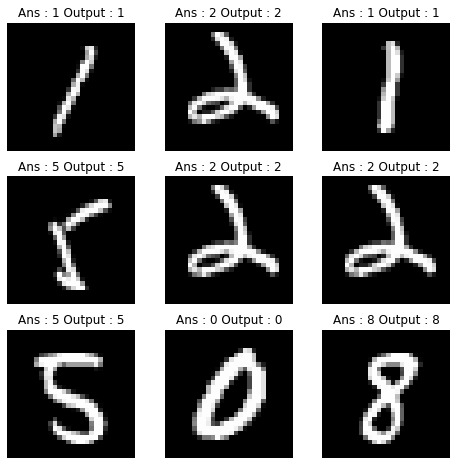

In [5]:
# 推論結果の表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 3, 3
for i in range(rows * cols):
    idx = torch.randint(low = 0, high = len(imgs), size = (1, 1)).item()
    # データの取得
    img, label = imgs[idx], labels[idx]
    figure.add_subplot(cols, rows, i + 1)
    plt.title(f"Ans : {label.item()} Output : {model(img).argmax(axis=1).item()}")
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap = "gray")
plt.show()

# LIMEを用いた分類結果の説明
<code>explain_instance</code>:
<table>
    <tr>
        <th>引数名</th>
        <th><p>説明</p></th>
    </tr>
    <tr>
        <td>image</td>
        <td><p>RGB画像（2次元配列の場合は、グレースケールと想定され、gray2rgbが呼び出される）</p></td>
    </tr>
    <tr>
        <td>classifier_fn</td>
        <td><p>numpy配列を受け取り、予測確率を出力する関数</p></td>
    </tr>
    <tr>
        <td>top_labels</td>
        <td><p>Noneでない場合、ラベルを無視し、予測確率が最も高いK個（Kはこのパラメータ）のラベルについて説明を生成する</p></td>
    </tr>
    <tr>
        <td>hide_color</td>
        <td><p>Noneでない場合、この色でスーパーピクセルを隠す。それ以外の場合は、画像の平均画素色を使用する。</p></td>
    </tr>
    <tr>
        <td>num_samples</td>
        <td><p>線形モデルを学習するための近傍領域のサイズ</p></td>
    </tr>
    <tr>
        <td>segmentation_fn</td>
        <td><p>SegmentationAlgorithm</p></td>
    </tr>
</table><br>
<code>SegmentationAlgorithm</code>:
<table>
    <tr>
        <th>引数名</th>
        <th><p>説明</p></th>
    </tr>
    <tr>
        <td>algo_type</td>
        <td><p>以下の中から選択されたセグメンテーションアルゴリズム（quickshift, slic, felzenszwalb）</p></td>
    </tr>
    <tr>
        <td>target_params</td>
        <td><p>アルゴリズムのパラメータ</p></td>
    <tr>
</table>
<code>batch_predict</code>:<br>
explain_instance関数内で学習モデルの予測関数が使用できるように、入力をnumpy型からTensor型に変換後、学習モデルで予測を行い、explain_instanceで使用できるようにnumpy型に修正し戻り値を返す関数

In [6]:
def batch_predict(np_rgb_imgs):
    # RGB画像をモノクロ画像に変換
    np_imgs = np.zeros((len(np_rgb_imgs), 1, 28, 28))
    for i, np_rgb_img in enumerate(np_rgb_imgs):
        np_imgs[i, 0, :, :] = (np_rgb_img[:, :, 0] + np_rgb_img[:, :, 1] + np_rgb_img[:, :, 2]) / 3 
    
    # numpy型をTensor型に変更
    tensor_imgs = torch.from_numpy(np_imgs).to(torch.float32)
    
    # 予測結果をnumpyに変換しreturn
    return model(tensor_imgs).detach().numpy()

In [7]:
imgs, labels = next(iter(dataloaders_dict["test"]))
explainer = lime_image.LimeImageExplainer()
segmenter = SegmentationAlgorithm(algo_type='quickshift', kernel_size=1, max_dist=200, ratio=0.2)
explanation = explainer.explain_instance(image = imgs[0].squeeze().numpy(),
                                         classifier_fn = batch_predict,
                                         top_labels=10,
                                         hide_color=0,
                                         num_samples=10000,
                                         segmentation_fn=segmenter
)

  0%|          | 0/10000 [00:00<?, ?it/s]

## 各クラスごとの説明

Ans : 3, Output : 3


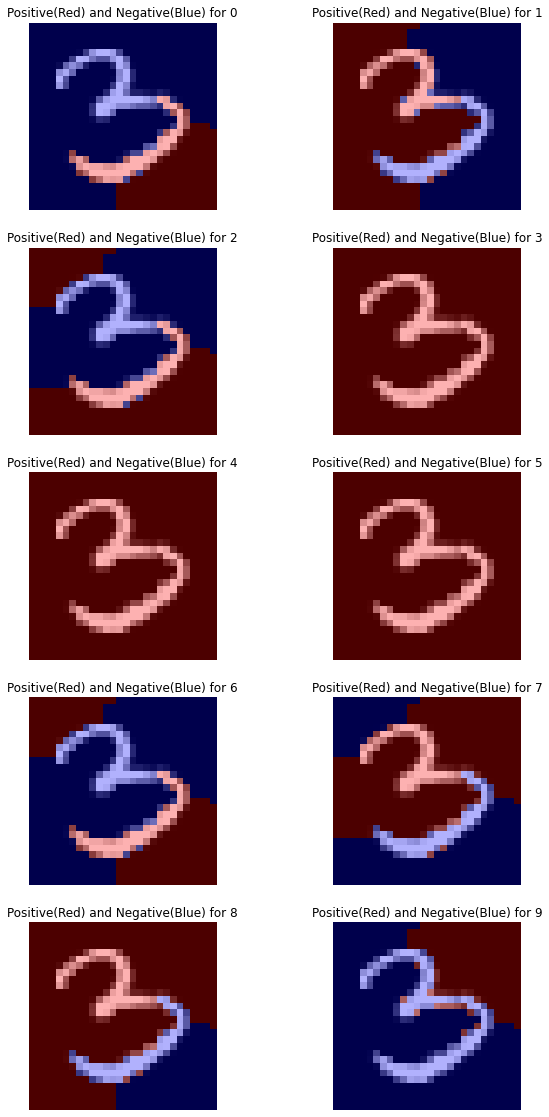

In [8]:
fig, m_axs = plt.subplots(5,2, figsize = (10, 20))
print(f"Ans : {labels[0]}, Output : {model(imgs[0]).argmax(axis=1).item()}")
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=False, num_features=10, hide_rest=False)
    c_ax.imshow(label2rgb(3-mask, imgs[0].squeeze().numpy(), bg_label = 0), interpolation = 'nearest')
    c_ax.set_title(f'Positive(Red) and Negative(Blue) for {i}')
    c_ax.axis('off')